In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

In [2]:
def generateData(size,dimesion, matrix_row):
    #parameters of data
    n_size=size
    n_train=int(size*0.8)
    n_test = n_size - n_train
    dimesion_x = dimesion
    row_size_matrix = matrix_row
    print("size of data:", size)
    print("training size:", n_train)
    print("testing size:", n_test)
    print("dimesion of the input:", dimesion)
    print("dimesion of the output:",matrix_row)

    #Data Generation
    np.random.seed(42)
    x=np.random.rand(n_size,dimesion_x)*18-9
    #create a dimesion_x * 2 matrix 
    a=np.random.rand(dimesion_x,row_size_matrix)
    #take the dot product between Matrix A and each vector in x.  
    ax=[]
    for i in range(n_size):
        ax.append(np.dot(x[i],a))
    ax=np.array(ax)
    y=np.sin(ax)

    #shuffles the indices
    idx=np.arange(n_size)
    np.random.shuffle(idx)

    #uses first 80% random indices for train
    train_idx = idx[:n_train]
    #Ues the remaining indices for validation 
    val_idx = idx[n_train:]

    #Generates train and validation sets
    x_train, ax_train, y_train = x[train_idx], ax[train_idx], y[train_idx]
    x_test, ax_test, y_test = x[val_idx], ax[val_idx], y[val_idx]
    #add noises
    y_train += (np.random.randn(n_train, row_size_matrix)/20)
    y_test += (np.random.randn(n_test, row_size_matrix)/20)
    return x_train, ax_train, y_train, x_test, ax_test, y_test
    

In [3]:
from torch.utils.data import Dataset, TensorDataset

class Dataset(Dataset):
    def __init__(self, x, y):
        self.length=x.shape[0]
        
        self.x_data = torch.from_numpy(x).type(torch.FloatTensor)
        self.y_data = torch.from_numpy(y).type(torch.FloatTensor)
        
    def __getitem__(self, index):
        return (self.x_data[index], self.y_data[index])

    def __len__(self):
        return self.length


In [4]:
# I decide to use three hidden layers for my neural network and Relu as my activation function
# The configuration is dimesion_x/64/64/64/row_size_matrix
# I am trying to figure out how will the ideal number of layers and nodes be for our problem.
class simpleNet(nn.Module):
    def __init__(self, dimesion_x, row_size_matrix):
        super(simpleNet, self).__init__()
        
        #Define dimesions of layers 
        D_in, H1, H2, H3, D_out = [dimesion_x, 64, 64, 64, row_size_matrix]
        
        #Define layers
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)
    def forward(self,x):
        
        x = self.linear1(x)
        x = F.relu(x)
        
        x = self.linear2(x)
        x = F.relu(x)
        
        x = self.linear3(x)
        x = F.relu(x)
        
        x = self.linear4(x)
        #x = F.relu(x)
        
        #x = self.linear5(x)
        return x


In [5]:
def make_train_step(model, loss_fn, optimizer):
    
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        
        # Makes predictions
        y_predict = model.forward(x)
        
        # Computes loss
        loss = loss_fn(y, y_predict)
        
        #zeroes gradients 
        optimizer.zero_grad()
        
        # Computes gradients
        loss.backward()
        
        # Updates parameters
        optimizer.step()
        
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

#training

def train(model, loader, loss_fn, optimizer, nepochs):
    '''
    @brief Train the model with specfic parameters 
    @param model: the model that needs to be train
    @param loader: dataLoader that contains the training data
    @param loss_fn: the loss function that will be used when caculating loss
    @param optimizer
    @param nepochs
    @return losses: training losses of all batchs for all the epochs
    
    '''
    losses = []
    total_losses = []
    train_step = make_train_step(model, loss_fn, optimizer)
    count=1;
    for epoch in range(nepochs):
        sum_loss=0
        for x_batch, y_batch in loader:
            loss = train_step(x_batch, y_batch)
            sum_loss = loss + sum_loss
            losses.append(loss)
        total_losses.append(sum_loss)
    plt.plot(total_losses)
    return losses


In [6]:
def test_batch(model, x, y):
    y_predict = model.forward(x)
    
    return y, y_predict

def test(model, loader):
    y_vector=[]
    y_predict_vector=[]
    for x, y in loader:
        y, y_predict = test_batch(model,x,y)    
        y_vector.append(y.data.numpy())
        y_predict_vector.append(y_predict.data.numpy())
    return np.concatenate(y_predict_vector)


In [7]:
def run(data_train, data_test,batch_size_train, lr, dimesion_x, row_size_matrix,epoch):
    
    #print 
    print("batch size:", batch_size_train)
    print("learning rate:",lr)
    print("number of epochs:", epoch)
    
    #divided the data into different batches
    data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size_train, shuffle=True)
    data_loader_test = DataLoader(dataset=dataset_test, batch_size=len(dataset_test), shuffle=False)
    
    #define model, loss function, optimizer
    loss_fn = nn.MSELoss(reduction='mean')
    model = simpleNet(dimesion_x, row_size_matrix) 
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    #get losses and the preditions of the model
    losses=train(model, data_loader_train,loss_fn, optimizer, epoch)
    y_predict = test(model, data_loader_test)
    
    return losses, y_predict
    

size of data: 50000
training size: 40000
testing size: 10000
dimesion of the input: 1
dimesion of the output: 2
batch size: 16
learning rate: 0.001
number of epochs: 10


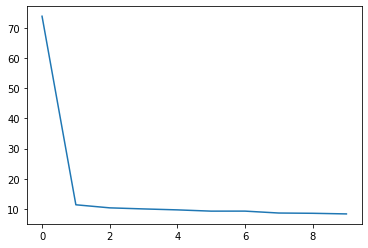

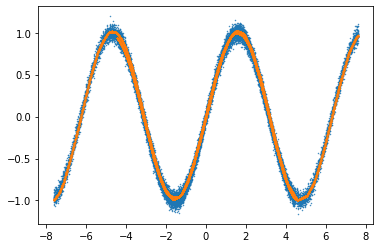

In [8]:
x_train, ax_train, y_train, x_test, ax_test, y_test = generateData(50000,1,2)
dataset_train = Dataset(x_train, y_train)
dataset_test = Dataset(x_test, y_test)
loss, y_predict = run(dataset_train,dataset_test,16,1e-3,1,2,10)

fig1 = plt.figure()  # initialize a plot
plt.scatter(ax_test, y_test, marker='o', s=0.2)  # plot x vs y
plt.scatter(ax_test, y_predict, marker='o', s=0.2)  # plot x vs y
plt.show()

size of data: 50000
training size: 40000
testing size: 10000
dimesion of the input: 2
dimesion of the output: 2
batch size: 16
learning rate: 0.001
number of epochs: 20


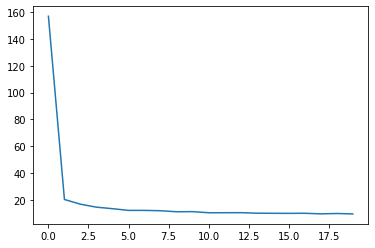

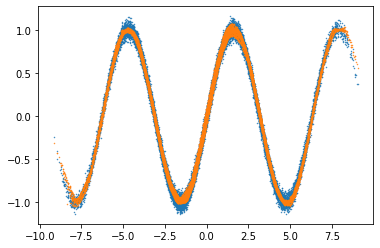

In [9]:
x_train, ax_train, y_train, x_test, ax_test, y_test = generateData(50000,2,2)
dataset_train = Dataset(x_train, y_train)
dataset_test = Dataset(x_test, y_test)
loss, y_predict = run(dataset_train,dataset_test,16,1e-3,2, 2,20)

fig1 = plt.figure()  # initialize a plot
plt.scatter(ax_test, y_test, marker='o', s=0.2)  # plot x vs y
plt.scatter(ax_test, y_predict, marker='o', s=0.2)  # plot x vs y
plt.show()

size of data: 50000
training size: 40000
testing size: 10000
dimesion of the input: 3
dimesion of the output: 2
batch size: 16
learning rate: 0.001
number of epochs: 10


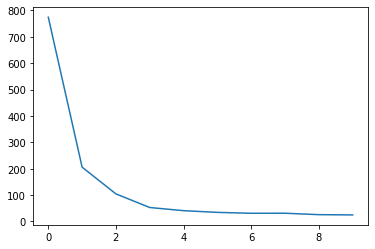

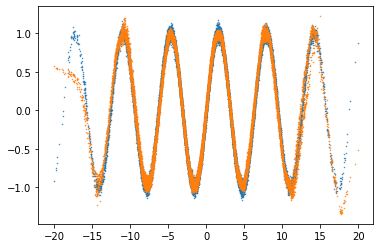

In [10]:
x_train, ax_train, y_train, x_test, ax_test, y_test = generateData(50000,3,2)
dataset_train = Dataset(x_train, y_train)
dataset_test = Dataset(x_test, y_test)
loss, y_predict = run(dataset_train,dataset_test,16,1e-3,3,2,10)

fig1 = plt.figure()  # initialize a plot
plt.scatter(ax_test, y_test, marker='o', s=0.2)  # plot x vs y
plt.scatter(ax_test, y_predict, marker='o', s=0.2)  # plot x vs y
plt.show()



size of data: 50000
training size: 40000
testing size: 10000
dimesion of the input: 4
dimesion of the output: 2
batch size: 16
learning rate: 0.001
number of epochs: 10


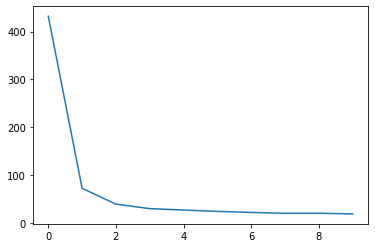

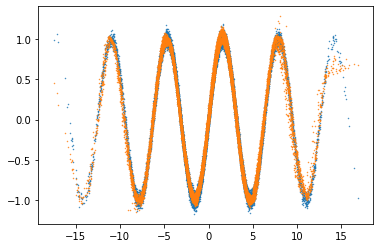

In [11]:
x_train, ax_train, y_train, x_test, ax_test, y_test = generateData(50000,4,2)
dataset_train = Dataset(x_train, y_train)
dataset_test = Dataset(x_test, y_test)
loss, y_predict = run(dataset_train,dataset_test,16,1e-3,4,2,10)

fig1 = plt.figure()  # initialize a plot
plt.scatter(ax_test, y_test, marker='o', s=0.2)  # plot x vs y
plt.scatter(ax_test, y_predict, marker='o', s=0.2)  # plot x vs y
plt.show()



size of data: 50000
training size: 40000
testing size: 10000
dimesion of the input: 6
dimesion of the output: 2
batch size: 16
learning rate: 0.001
number of epochs: 10


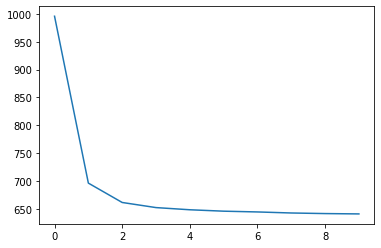

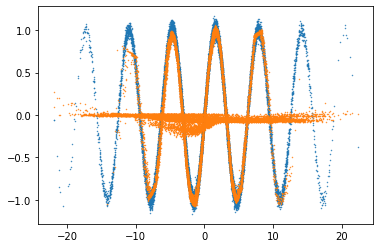

In [12]:
x_train, ax_train, y_train, x_test, ax_test, y_test = generateData(50000,6,2)
dataset_train = Dataset(x_train, y_train)
dataset_test = Dataset(x_test, y_test)
loss, y_predict = run(dataset_train,dataset_test,16,1e-3,6,2,10)

fig1 = plt.figure()  # initialize a plot
plt.scatter(ax_test, y_test, marker='o', s=0.2)  # plot x vs y
plt.scatter(ax_test, y_predict, marker='o', s=0.2)  # plot x vs y
plt.show()

size of data: 50000
training size: 40000
testing size: 10000
dimesion of the input: 5
dimesion of the output: 2
batch size: 16
learning rate: 0.001
number of epochs: 10


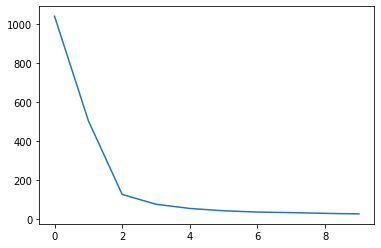

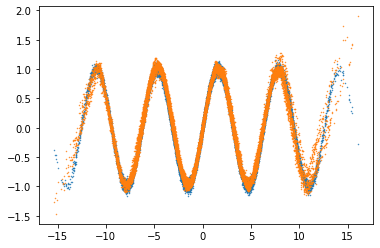

In [13]:
x_train, ax_train, y_train, x_test, ax_test, y_test = generateData(50000,5,2)
dataset_train = Dataset(x_train, y_train)
dataset_test = Dataset(x_test, y_test)
loss, y_predict = run(dataset_train,dataset_test,16,1e-3,5,2,10)

fig1 = plt.figure()  # initialize a plot
plt.scatter(ax_test, y_test, marker='o', s=0.2)  # plot x vs y
plt.scatter(ax_test, y_predict, marker='o', s=0.2)  # plot x vs y
plt.show()